# Import Package

In [23]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
print(f'''
{np.__version__},
{pd.__version__},
{tf.__version__}''')


1.21.6,
1.3.5,
2.8.2


In [4]:
!python --version

Python 3.7.13


# Import Dataset

In [6]:
rating = pd.read_csv('rating_hotel_bali.csv')
hotel = pd.read_csv('hotel.csv')
user = pd.read_csv('user.csv')

In [7]:
# melihat ukuran data
print(f'rating : {rating.shape}')
print(f'hotel : {hotel.shape}')
print(f'user : {user.shape}')

rating : (10000, 3)
hotel : (110, 11)
user : (300, 3)


# Persiapan Dataset

In [8]:
# Merubah data agar hanya dari Kota Bali

hotel = hotel[hotel['City']=='Bali']
hotel.head()

,id,Name,City,Ratings,Price,Addres,Coordinate,Description,Lat,Long,Images
60,61,The Alea Hotel Seminyak,Bali,4.2,"4,403,576.00","Jl. Cendrawasih No.78, Seminyak, Kec. Kuta Uta...","-8.67463167686094, 115.15341976860144","Set on a narrow, winding street, this upmarket...",-8.674632,115.153420,https://pix10.agoda.net/hotelImages/569/569051...
61,62,Atanaya Kuta Bali,Bali,4.4,"275,705.00","Jl. Sunset Road No.88A, Kuta, Kec. Kuta, Kabup...","-8.70357015159306, 115.18059606116576","This modern, casual hotel is an 8-minute walk ...",-8.703570,115.180596,https://cf.bstatic.com/xdata/images/hotel/max1...
62,63,Grand Livio Kuta Hotel,Bali,4.4,"176,762.00","Jl. Dewi Sri No.17, Kuta, Kec. Kuta, Kabupaten...","-8.707926067445976, 115.1789058788881",A 6 km drive from Bali Ngurah Rai Internationa...,-8.707926,115.178906,https://pix10.agoda.net/hotelImages/161/161264...
63,64,Mega Boutique Hotel & Spa,Bali,4.3,"305,266.00","SImpang Siur, Jl. Bypass Ngurah Rai No.259, Ku...","-8.721310373139259, 115.18644739196829",Among shops and eateries on a bustling commerc...,-8.721310,115.186447,https://s-light.tiket.photos/t/01E25EBZS3W0FY9...
64,65,The ONE Legian,Bali,4.3,"283,500.00","Jl. Raya Legian No.117, Kuta, Kec. Kuta, Kabup...","-8.714040123752303, 115.17360076101478",In a tree-lined area near shops and restaurant...,-8.714040,115.173601,https://dynamic-media-cdn.tripadvisor.com/medi...


In [9]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,83,3
1,1,83,2
2,1,108,5
3,1,83,3
4,1,68,4


In [10]:
df = rating.copy()

In [11]:
#ENCODING
def dict_encoder(col, data=df):
  unique_val = data[col].unique().tolist()
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [12]:
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [13]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [14]:
# Mendapatkan jumlah user dan hotel
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
# mengubah nilai rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

In [15]:
print(f'Jumlah user : {num_users}')
print(f'Jumlah Hotel : {num_place}')
print(f'Rating minimum : {min_rating}')
print(f'Rating maximum : {max_rating}')

Jumlah user : 300
Jumlah Hotel : 49
Rating minimum : 1.0
Rating maximum : 5.0


In [16]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head()

,User_Id,Place_Id,Place_Ratings,user,place
6252,188,71,3.0,187,28
4684,142,101,2.0,141,40
1731,54,97,3.0,53,21
4742,144,106,3.0,143,25
4521,138,74,5.0,137,26


# Splitting Dataset

In [17]:
# Mambuat Variable x
x = df[['user', 'place']].values
# membuat Variable y
y = df['Place_Ratings'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values

# split dataset
indices = int(0.8*df.shape[0])
x_train, x_test, y_train, y_test = (x[:indices],
                                    x[indices:],
                                    y[:indices],
                                    y[indices:]
                                    )
print(f'x_train : {x_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

x_train : (8000, 2)
x_test : (2000, 2)
y_train : (8000,)
y_test : (2000,)


In [18]:
class Recommended(keras.Model):
  def __init__(self,num_users, num_places, embedding_size, **kwargs):
    super(Recommended, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(num_users,
                                           embedding_size,
                                           embeddings_initializer = 'he_normal',
                                           embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users,1)
    self.places_embedding = layers.Embedding(num_places,
                                             embedding_size,
                                             embeddings_initializer='he_normal',
                                             embeddings_regularizer= keras.regularizers.l2(1e-6)
                                             )
    self.places_bias = layers.Embedding(num_places,1)

  def call(self, inputs):
    user_vec = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    places_vec = self.places_embedding(inputs[:,1])
    places_bias = self.places_bias(inputs[:,1])

    dot_user_places = tf.tensordot(user_vec, places_vec, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x)


In [19]:
model = Recommended(num_users, num_place, 50)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# training Model

In [20]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 50,
    validation_data = (x_test, y_test)
)

Epoch 1/50
250/250 [==============================] - 2s 3ms/step - loss: 0.7457 - root_mean_squared_error: 0.3774 - val_loss: 0.7332 - val_root_mean_squared_error: 0.3696
Epoch 2/50
250/250 [==============================] - 1s 3ms/step - loss: 0.7394 - root_mean_squared_error: 0.3736 - val_loss: 0.7312 - val_root_mean_squared_error: 0.3685
Epoch 3/50
250/250 [==============================] - 1s 3ms/step - loss: 0.7304 - root_mean_squared_error: 0.3688 - val_loss: 0.7282 - val_root_mean_squared_error: 0.3666
Epoch 4/50
250/250 [==============================] - 1s 2ms/step - loss: 0.7230 - root_mean_squared_error: 0.3644 - val_loss: 0.7272 - val_root_mean_squared_error: 0.3662
Epoch 5/50
250/250 [==============================] - 1s 3ms/step - loss: 0.7305 - root_mean_squared_error: 0.3688 - val_loss: 0.7247 - val_root_mean_squared_error: 0.3647
Epoch 6/50
250/250 [==============================] - 1s 3ms/step - loss: 0.7240 - root_mean_squared_error: 0.3649 - val_loss: 0.7242 - val_

# Evaluasi Model

In [21]:
model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.7057 - root_mean_squared_error: 0.3533


[0.7056776285171509, 0.3533383905887604]

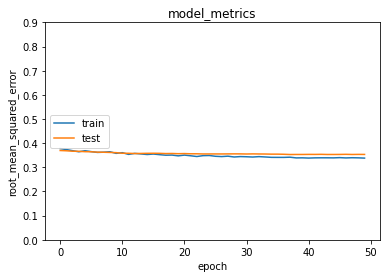

In [24]:
# Menampilkan plot loss dan validation

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.9)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# Penerapan Model

In [26]:
hotel.columns

Index(['id', 'Name', 'City', 'Ratings', 'Price', 'Addres', 'Coordinate',
       'Description', 'Lat', 'Long', 'Images'],
      dtype='object')

In [25]:
place_df = hotel[['id', 'Name', 'City', 'Ratings', 'Price', 'Addres', 'Coordinate',
       'Description', 'Lat', 'Long', 'Images']]
place_df.columns = ['id', 'Name', 'City', 'Ratings', 'Price', 'Addres', 'Coordinate',
       'Description', 'Lat', 'Long', 'Images']
df = rating.copy()

In [27]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [28]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user.Place_Id.values)]['id'] 
place_not_visited = list(
    set(place_not_visited).intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [29]:
# Mengambil top 5 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 

print('')
print('----' * 15)
print('Top 5 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.Name, '\n    ', row.Addres, ',', 'Harga Tiket Masuk ', row.Price, ',', 'Rating Wisata ', row.Ratings,'\n')

print('==='*15)


------------------------------------------------------------
Top 5 place recommendation
------------------------------------------------------------
1 . The Alea Hotel Seminyak 
     Jl. Cendrawasih No.78, Seminyak, Kec. Kuta Utara, Kabupaten Badung, Bali 80361 , Harga Tiket Masuk  4,403,576.00 , Rating Wisata  4.2 

2 . Grand Livio Kuta Hotel 
     Jl. Dewi Sri No.17, Kuta, Kec. Kuta, Kabupaten Badung, Bali 80361 , Harga Tiket Masuk  176,762.00 , Rating Wisata  4.4 

3 . The ONE Legian 
     Jl. Raya Legian No.117, Kuta, Kec. Kuta, Kabupaten Badung, Bali 80361 , Harga Tiket Masuk  283,500.00 , Rating Wisata  4.3 

4 . Ramada Encore by Wyndham Bali Seminyak 
     Jl. Dewi Saraswati III, Seminyak, Kec. Kuta, Kota Denpasar, Bali 80361 , Harga Tiket Masuk  321,555.00 , Rating Wisata  4.3 

5 . Hawaii Bali Villa 
     Jl. Tukad Balian No.899X, Sanur, Denpasar Selatan, Kota Denpasar, Bali 80361 , Harga Tiket Masuk  Nan , Rating Wisata  4.4 



# Save Model

In [32]:
model.save_weights('./model_hotel_bali/my_checkpoint')

In [33]:
model_load = Recommended(num_users, num_place, 50)
model_load.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0004),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model_load.load_weights('./model_hotel_bali/my_checkpoint')